# Machine Learning 2 - Semester Project 
# Garbage Classification

<div class="alert alert-block alert-info">
<b>Tip:</b> Revised Order:

1. **Data Collection:**
   - Collect a dataset of images representing different types of garbage items (plastic, paper, glass, etc.).
   - Found multiple data sets on kaggle
    
2. **Image Classification:**
   - Use convolutional neural networks (CNNs) to build an image classification model.
   - Train the model to recognize and classify each type of garbage item.
   - Evaluate the model's performance using appropriate metrics.

3. **Pre-trained Models Comparison:**
   - Choose popular pre-trained models for image classification (e.g., ResNet, VGG, MobileNet).
   - Fine-tune these models on your garbage classification dataset.
   - Evaluate the performance of the fine-tuned models.
   - Compare the performance metrics with your custom-trained model.

4. **Clustering and Dimension Reduction:**
   - Apply clustering algorithms (e.g., K-Means) to group similar garbage items together.
        - (Hope to find clusters like: recycleable/ bio/ others
   - Use dimension reduction techniques (e.g., PCA) to visualize and analyze the features of the garbage items.

5. **Integrating Recommendations:**
   - Implement a recommendation system that suggests the appropriate recycling bin for a given item.
        - maybe simple tree?? 
   - Use knowledge from the clustering and dimension reduction to enhance recommendation accuracy.


</div>


## Project Description
### -  Real Problem: Cannot indicate which picture is what kind of garbage
### - Problem Setting: Precise categorization of waste/garbage images into specific labels 
### - Application: Waste separation within a disposal facility/process. Specific problem: More efficient waste separation in preprocessing for lower waste gas emissions. 

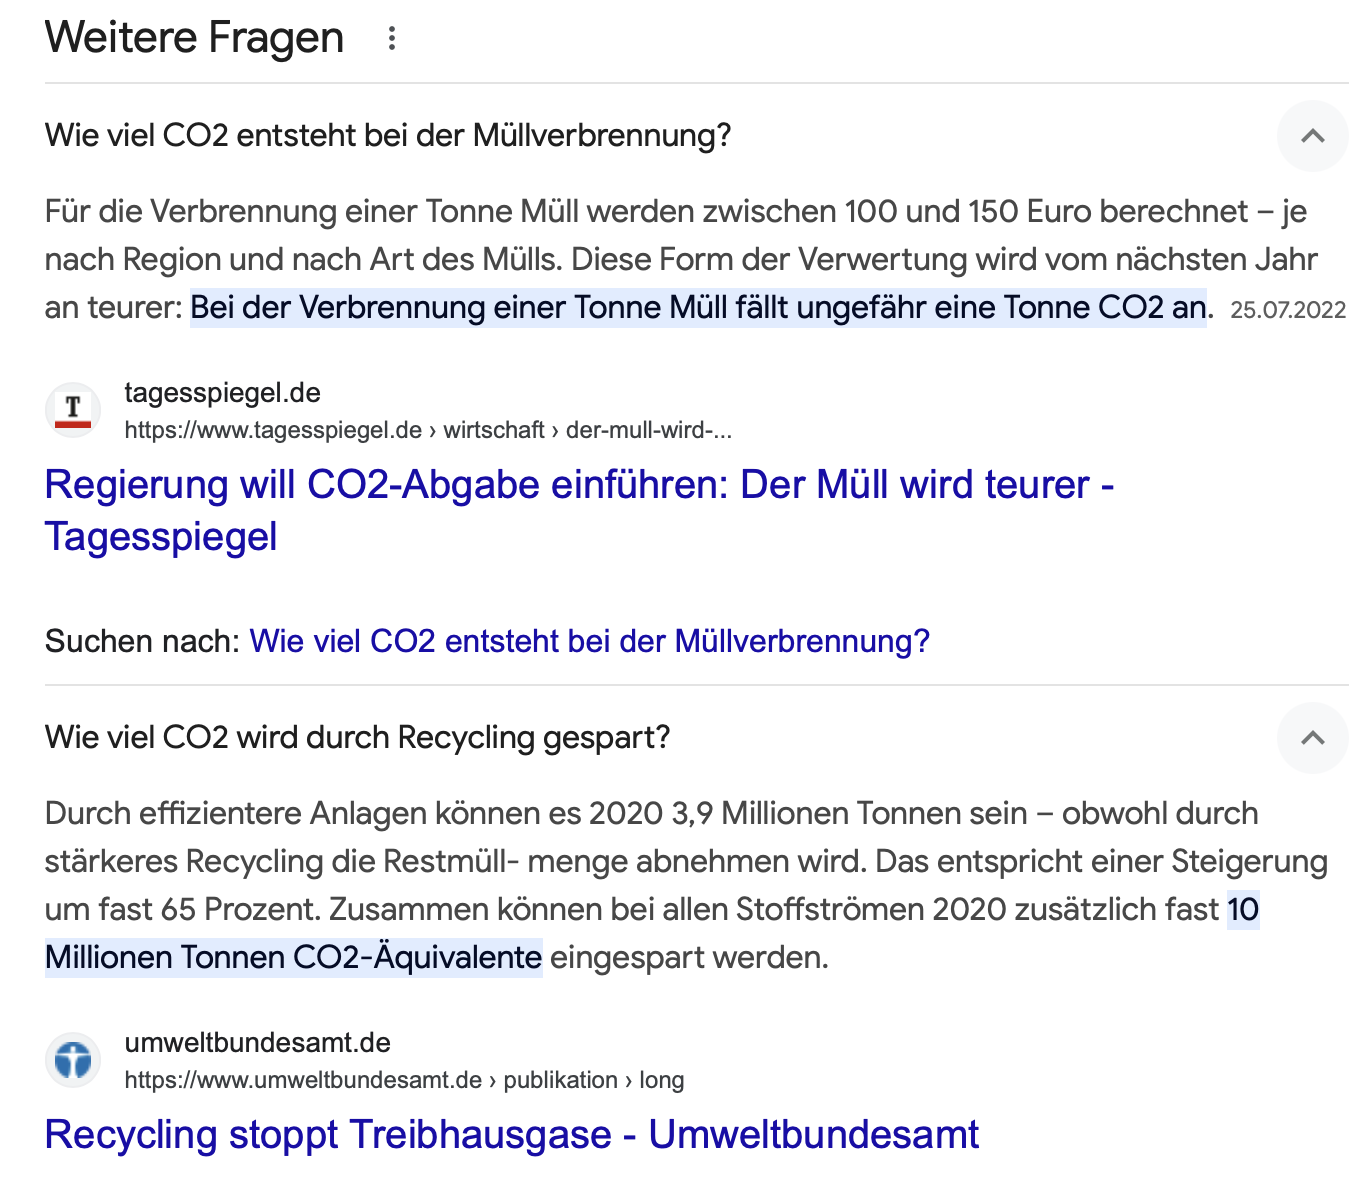

### Import Libraries

In [1]:
# Standard Libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries for Images 
import os
import glob
from PIL import Image

# Libraries for Evaluations and Train/Test Split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Model Libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from kerastuner.tuners import BayesianOptimization
#import keras_turner
from kerastuner.tuners import BayesianOptimization
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

#VGG16
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam


#ResNET
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

#Statistical Test
from scipy.stats import ttest_rel
from sklearn.metrics import accuracy_score

#Evaluation
from sklearn.metrics import accuracy_score
from scipy.stats import ttest_rel
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

#Model Visualization
from ann_visualizer.visualize import ann_viz
from tensorflow.keras.utils import plot_model


#Others
from tqdm import tqdm  # Optional: tqdm for progress bar
from concurrent.futures import ThreadPoolExecutor

/var/folders/2b/c643wm_d7xl9868bh1t2r6n80000gn/T/ipykernel_1204/2448331543.py:20: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import BayesianOptimization


## Download Data for Images 

In [2]:
def count_images_in_subfolders(root_folder, image_extensions=['jpg', 'jpeg', 'png', 'gif', 'bmp']):
    # Ensure the root folder path is valid
    if not os.path.exists(root_folder):
        print(f"Error: The folder '{root_folder}' does not exist.")
        return None
    # Initialize an empty list to store results
    data = []

    # Iterate through subfolders
    for subfolder_name in os.listdir(root_folder):
        subfolder_path = os.path.join(root_folder, subfolder_name)

        # Check if it's a directory
        if os.path.isdir(subfolder_path):
            # Use glob to count images in the subfolder
            image_files = []
            for ext in image_extensions:
                image_files.extend(glob.glob(os.path.join(subfolder_path, f'*.{ext}')))

            # Count the number of images
            num_images = len(image_files)

            # Append the results to the list
            data.append({'Classes': subfolder_name, 'Number_Images': num_images})

    # Convert the list to a DataFrame
    df = pd.DataFrame(data)

    return df

In [3]:
# Example usage:
root_folder_path = '/Users/linuszarse/Documents/UNI/Master-Uni Potsdam/3. Semester/Machine Learning 2/Klausurprojekt/garbage_classification/'
image_overview = count_images_in_subfolders(root_folder_path)

image_overview

,Classes,Number_Images
0,paper,1050
1,green-glass,629
2,clothes,5325
3,metal,769
4,cardboard,891
5,trash,697
6,biological,985
7,white-glass,775
8,battery,945
9,brown-glass,607


In [4]:
image_overview['Number_Images'].sum()

15515

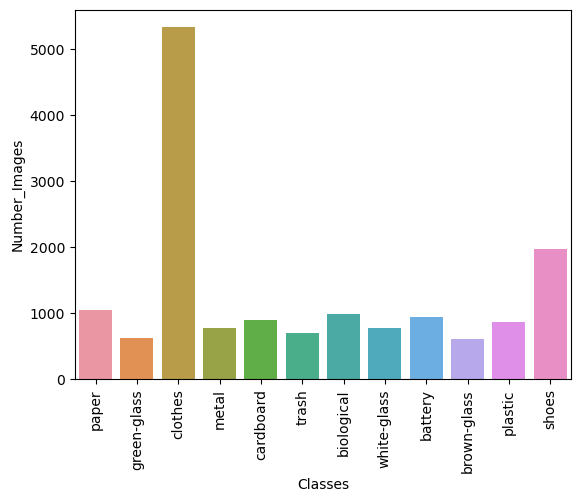

In [5]:
sns.barplot(image_overview, x="Classes", y="Number_Images")
plt.xticks(rotation=90)
plt.show()

### Use ImageData Generator 

In [7]:
root_folder_path = '/Users/linuszarse/Documents/UNI/Master-Uni Potsdam/3. Semester/Machine Learning 2/Klausurprojekt/garbage_classification'

# Define the ImageDataGenerator for data augmentation and preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,       # Rescale pixel values to be between 0 and 1
    shear_range=0.2,      # Shear transformation
    zoom_range=0.2,       # Random zoom
    horizontal_flip=True, # Random horizontal flip
    validation_split=0.2  # Split data into training and validation sets
)

# Define the target image size
target_size = (256,256)  # Adjust according to your model's input size

# Create the training data generator
train_generator = datagen.flow_from_directory(
    root_folder_path,
    target_size=target_size,
    batch_size=32,         # Adjust based on your system's memory
    class_mode='categorical',  # Assumes a classification task
    subset='training'      # Specify 'training' for training data
)

# Create the validation data generator
validation_generator = datagen.flow_from_directory(
    root_folder_path,
    target_size=target_size,
    batch_size=32,
    class_mode='categorical',
    subset='validation'    # Specify 'validation' for validation data
)


Found 12415 images belonging to 12 classes.
Found 3100 images belonging to 12 classes.


In [8]:
class_names = list(train_generator.class_indices.keys())
print("Class Names:", class_names)

Class Names: ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']


In [9]:
# Get a batch from the training generator
#batch_images, batch_labels = next(train_generator)

# Visualize the first few images in the batch
#num_images_to_visualize = 12
#for i in range(num_images_to_visualize):
    # Get the image and label
#    image = batch_images[i]
#    label_index = np.argmax(batch_labels[i])
    
    # Plot the image
#    plt.imshow(image)
#    plt.title(f"Label: {label_index}")
#    plt.show()

In [10]:
# Get a batch from the training generator
#batch_images, batch_labels = next(validation_generator)

# Visualize the first few images in the batch
#num_images_to_visualize = 5
#for i in range(num_images_to_visualize):
#    # Get the image and label
#    image = batch_images[i]
#    label_index = np.argmax(batch_labels[i])
#    
#    # Plot the image
#    plt.imshow(image)
#    plt.title(f"Label: {label_index}")
#    plt.show()

In [11]:
# Visualize the first few images in the batch with class names
#for i in range(num_images_to_visualize):
#    # Get the image and label
#    image = batch_images[i]
#    label_index = np.argmax(batch_labels[i])
#    class_name = class_names[label_index]
#    
#    # Plot the image
#    plt.imshow(image)
#    plt.title(f"Class Name: {class_name}")
#    plt.show()


***
## Definition of Test Statistics

In [12]:
#test for signifcants different 
#the model's performance is not significantly different from random chance ??
def evaluate_model(model, validation_generator, alpha=0.05):
    # Assuming you have true labels for the validation set
    true_labels = validation_generator.classes  # Assuming you're using flow_from_directory

    # Make predictions on the validation set
    predicted_labels = model.predict(validation_generator)

    # Convert predicted probabilities to class labels
    predicted_labels = np.argmax(predicted_labels, axis=1)

    # Calculate the test statistic (accuracy)
    observed_accuracy = accuracy_score(true_labels, predicted_labels)

    # Perform a paired t-test
    t_statistic, p_value = ttest_rel(true_labels, predicted_labels)

    # Check if the p-value is less than alpha
    if p_value < alpha:
        print("Reject the null hypothesis. There is a significant difference.")
    else:
        print("Fail to reject the null hypothesis. No significant difference.")

    # Print additional information
    print(f"Observed Accuracy: {observed_accuracy:.4f}")
    print(f"T-Statistic: {t_statistic:.4f}")
    print(f"P-Value: {p_value:.4f}")

#example: evaluate_model(your_trained_model, your_validation_generator)

In [13]:
def compare_models(model_A, model_B, test_data, validation_generator, alpha=0.05):
    # Assuming you have true labels for the test set
    true_labels = validation_generator.classes  # Ground truth labels

    # Make predictions on the test set for both models
    predicted_labels_model_A = model_A.predict(test_data)
    predicted_labels_model_B = model_B.predict(test_data)

    # Convert predicted probabilities to class labels
    predicted_labels_model_A = np.argmax(predicted_labels_model_A, axis=1)
    predicted_labels_model_B = np.argmax(predicted_labels_model_B, axis=1)

    # Calculate the test statistic (accuracy)
    accuracy_model_A = accuracy_score(true_labels, predicted_labels_model_A)
    accuracy_model_B = accuracy_score(true_labels, predicted_labels_model_B)

    # Perform a paired t-test
    t_statistic, p_value = ttest_rel(accuracy_model_A, accuracy_model_B)

    # Check if the p-value is less than alpha
    if p_value < alpha:
        print("Reject the null hypothesis. There is a significant difference.")
    else:
        print("Fail to reject the null hypothesis. No significant difference.")

    # Print additional information
    print(f"Accuracy Model A: {accuracy_model_A:.4f}")
    print(f"Accuracy Model B: {accuracy_model_B:.4f}")
    print(f"T-Statistic: {t_statistic:.4f}")
    print(f"P-Value: {p_value:.4f}")

## Example usage:
#compare_models(your_model_A, your_model_B, your_test_data, your_validation_generator)


In [14]:
from scipy.stats import ttest_rel

def compare_model_performance(fold_performance_model_1, avg_perf_model_1, fold_performance_model_2, avg_perf_model_2):
    """
    Compare the performance of two models using a paired t-test.

    Args:
    fold_performance_model_1 (list): Performance of each fold for the first model.
    avg_perf_model_1 (float): Average performance of the first model.
    fold_performance_model_2 (list): Performance of each fold for the second model.
    avg_perf_model_2 (float): Average performance of the second model.
    """
    
    # Perform a paired t-test
    t_statistic, p_value = ttest_rel(fold_performance_model_1, fold_performance_model_2)

    print(f"Model 1 Average Performance: {avg_perf_model_1}")
    print(f"Model 2 Average Performance: {avg_perf_model_2}")
    print("T-Statistic:", t_statistic)
    print("P-Value:", p_value)

    if p_value < 0.05:
        print("The difference in performance is statistically significant.")
        if avg_perf_model_1 > avg_perf_model_2:
            print("Model 1 performs significantly better than Model 2.")
        else:
            print("Model 2 performs significantly better than Model 1.")
    else:
        print("No significant difference in performance.")

# Example usage
# compare_model_performance(fold_performance_model_1, avg_perf_model_1, fold_performance_model_2, avg_perf_model_2)


*** 
## Definition K-Fold Cross Validation Function

In [15]:
from sklearn.model_selection import KFold
from tensorflow.keras.models import clone_model

def k_fold_cross_validation(original_model, train_generator, n_splits=5, epochs=5):
    # Extracting data and labels from the generator
    dataset_size = train_generator.n
    num_classes = len(train_generator.class_indices)
    batch_size = train_generator.batch_size
    target_size = train_generator.target_size

    X = np.zeros((dataset_size, target_size[0], target_size[1], 3), dtype=np.float32)
    y = np.zeros((dataset_size, num_classes), dtype=np.float32)

    for i in range(len(train_generator)):
        batch_x, batch_y = train_generator.next()
        X[i * batch_size:(i + 1) * batch_size] = batch_x
        y[i * batch_size:(i + 1) * batch_size] = batch_y

    # K-Fold Cross-Validation
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_performance = []

    for train_indices, val_indices in kf.split(X):
        # Splitting data
        X_train, X_val = X[train_indices], X[val_indices]
        y_train, y_val = y[train_indices], y[val_indices]

        # Cloning the original model structure
        model = clone_model(original_model)
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        # Training the model
        model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val))

        # Evaluating the model
        scores = model.evaluate(X_val, y_val, verbose=0)
        fold_performance.append(scores[1])  # Assuming [1] is accuracy

    # Average performance
    average_performance = np.mean(fold_performance)
    return fold_performance, average_performance

***
## Implementing CNN - own build

In [17]:
num_classes = len(train_generator.class_indices)


## CNN2 - max pooling, relu, batch normalization, dropout, 

In [ ]:
model_cnn2 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(num_classes, activation='softmax')
])

model_cnn2.compile(optimizer=tf.keras.optimizers.legacy.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model_cnn2.summary()

    # Define a callback to save the best model during training
checkpoint = ModelCheckpoint("best_model_cnn2.h5", monitor='val_loss', save_best_only=True)
    # Define a callback to save the best model during training in the native Keras format
#checkpoint = ModelCheckpoint("best_model.keras", monitor='val_loss', save_best_only=True)


# Train the model
history = model_cnn2.fit(
    train_generator,
    epochs=10,  # Adjust the number of epochs based on your needs
    validation_data=validation_generator,
    callbacks=[checkpoint]
)


In [ ]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Assuming you have two models, model_1 and model_2
fold_performance_model_cnn2, avg_perf_model_cnn2 = k_fold_cross_validation(model_cnn2, train_generator, n_splits=5, epochs=5)


## CNN3 - max pooling, stride 1,2 , padding = valid, relu

In [19]:
# Define the CNN model
num_classes = len(train_generator.class_indices)

model_cnn3 = tf.keras.models.Sequential([
    Conv2D(32 , (3,3) , strides = 1 , padding = 'valid' , activation = 'relu', input_shape=(256, 256, 3)),
    MaxPooling2D((2,2) , strides = 2 , padding = 'valid'),

    Conv2D(64 , (3,3) , strides = 1 , padding = 'valid' , activation = 'relu'),
    MaxPooling2D((2,2) , strides = 2 , padding = 'valid'),
    
    Conv2D(64 , (3,3) , strides = 1 , padding = 'valid' , activation = 'relu'),
    MaxPooling2D((2,2) , strides = 2 , padding = 'valid'),
    
    Conv2D(128 , (3,3) , strides = 1 , padding = 'valid' , activation = 'relu'),
    MaxPooling2D((2,2) , strides = 2 , padding = 'valid'),
    
    Flatten(),
    Dense(units = 128 , activation = 'relu'),
    Dropout(0.2),
    Dense(units = num_classes, activation='softmax')  # Adjust 'num_classes' based on your task
])


# Compile the model
#model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Compile the model with the legacy Adam optimizer
model_cnn3.compile(optimizer=tf.keras.optimizers.legacy.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])


# Display the model summary
model_cnn3.summary()

    # Define a callback to save the best model during training
checkpoint = ModelCheckpoint("best_model_cnn3.h5", monitor='val_loss', save_best_only=True)
    # Define a callback to save the best model during training in the native Keras format
#checkpoint = ModelCheckpoint("best_model.keras", monitor='val_loss', save_best_only=True)


# Train the model
history = model_cnn3.fit(
    train_generator,
    epochs=100,  # Adjust the number of epochs based on your needs
    validation_data=validation_generator,
    callbacks=[checkpoint]
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 30, 30, 64)       

Epoch 41/100
388/388 [==============================] - 270s 695ms/step - loss: 0.1555 - accuracy: 0.9474 - val_loss: 1.0539 - val_accuracy: 0.7842
Epoch 42/100
388/388 [==============================] - 270s 694ms/step - loss: 0.1536 - accuracy: 0.9490 - val_loss: 1.1516 - val_accuracy: 0.7800
Epoch 43/100
388/388 [==============================] - 273s 702ms/step - loss: 0.1431 - accuracy: 0.9523 - val_loss: 1.1974 - val_accuracy: 0.7771
Epoch 44/100
388/388 [==============================] - 276s 711ms/step - loss: 0.1507 - accuracy: 0.9521 - val_loss: 1.1865 - val_accuracy: 0.7852
Epoch 45/100
388/388 [==============================] - 294s 755ms/step - loss: 0.1679 - accuracy: 0.9439 - val_loss: 1.2600 - val_accuracy: 0.7642
Epoch 46/100
388/388 [==============================] - 284s 731ms/step - loss: 0.1567 - accuracy: 0.9490 - val_loss: 1.0772 - val_accuracy: 0.7813
Epoch 47/100
388/388 [==============================] - 264s 680ms/step - loss: 0.1410 - accuracy: 0.9551 - val_

## With Hyperparameter Tuning:

In [10]:
from kerastuner.tuners import BayesianOptimization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

def build_model(hp):
    model = Sequential()
    
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    # Tuning the number and size of convolutional layers
    for i in range(hp.Int('num_conv_layers', 1, 3)):
        model.add(Conv2D(hp.Int(f'filters_{i}', 32, 128, 32), (3, 3), activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    
    # Tuning the number and size of dense layers
    for i in range(hp.Int('num_dense_layers', 1, 2)):
        model.add(Dense(hp.Int(f'units_{i}', 128, 512, 128), activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(hp.Float(f'dropout_{i}', 0.2, 0.5, 0.1)))
        # Adding L1/L2 regularization
        model.add(Dense(units=hp.Int(f'units_{i}', 128, 512, 128), 
                        activation='relu', 
                        kernel_regularizer=l1_l2(l1=hp.Float('l1', 1e-5, 1e-2, sampling='LOG', default=1e-5), 
                                                 l2=hp.Float('l2', 1e-5, 1e-2, sampling='LOG', default=1e-4))))

    model.add(Dense(num_classes, activation='softmax'))

    # Tuning the learning rate
    hp_lr = hp.Float('learning_rate', 1e-4, 1e-2, sampling='LOG')

    model.compile(optimizer=Adam(learning_rate=hp_lr), loss='categorical_crossentropy', metrics=['accuracy'])

    return model




In [11]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Bayesian Optimization tuner
tuner = BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    num_initial_points=2,
    directory='bayesian_optimization',
    project_name='garbage_classification'
)

tuner.search(train_generator, epochs=50, validation_data=validation_generator, callbacks=[early_stopping])

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 5 Complete [06h 49m 04s]
val_accuracy: 0.735161304473877

Best val_accuracy So Far: 0.7548387050628662
Total elapsed time: 12h 42m 57s


In [12]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the best hyperparameters
hyperparameter_model = build_model(best_hps)

# Train the best model (optional, as it was already trained during the search)
hyperparameter_model.fit(train_generator, epochs=10, validation_data=validation_generator)

# Save the best model
hyperparameter_model.save('hyperparameter_model.h5')


NameError: name 'tuner' is not defined

In [13]:
from tensorflow.keras.models import load_model
hyperparameter_model = load_model('hyperparameter_model.h5')
hyperparameter_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 batch_normalization_5 (Bat  (None, 254, 254, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 96)      27744     
                                                                 
 batch_normalization_6 (Bat  (None, 125, 125, 96)      384       
 chNormalization)                                                
                                                      

In [ ]:
fold_performance_hyperparameter_model, avg_perf_hyperparameter_model = k_fold_cross_validation(hyperparameter_model, train_generator, n_splits=2, epochs=1)


194/194 [==============================] - 373s 2s/step - loss: 7.0545 - accuracy: 0.4944 - val_loss: 7.2757 - val_accuracy: 0.1667


In [ ]:
fold_performance_hyperparameter_model

<div class="alert alert-block alert-info">
<b>Training Metrics Explanation:</b>

- **loss:**
  - The training loss at the end of the epoch. It represents the average value of the loss function across all training samples.

- **accuracy:**
  - The training accuracy at the end of the epoch. It represents the proportion of correctly classified training samples.

- **val_loss:**
  - The validation loss at the end of the epoch. It represents the average value of the loss function across all validation samples.
  
  Categorical Crossentropy Loss Formula:
  
  
  Categorical Crossentropy Loss =$ - \frac{1}{N} \sum_{i=1}^{N} \sum_{j=1}^{C} y_{i,j} \cdot \log(\hat{y}_{i,j})$

  Where:
    - $N$ is the number of samples in the batch.
    - $C$ is the number of classes.
    - $y_{i,j}$ is 1 if the true class of sample \(i\) is \(j\), 0 otherwise.
    - $(\hat{y}_{i,j})$ is the predicted probability that sample \(i\) belongs to class \(j\).

- **val_accuracy:**
  - The validation accuracy at the end of the epoch. It represents the proportion of correctly classified validation samples.
</div>


## Pre-Trained Models

***
## VGG16

In [24]:
# Check if a GPU is available
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU found. Please make sure you have a GPU and TensorFlow is configured to use it.")


# Load pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Create a new model and add pre-trained layers
model_VGG16 = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model_VGG16.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model_VGG16.summary()

# Define a callback to save the best model during training
checkpoint = ModelCheckpoint("best_model_resnet.h5", monitor='val_loss', save_best_only=True)

# Train the model
history = model_VGG16.fit(
    train_generator,
    epochs=10,  # Adjust the number of epochs based on your needs
    validation_data=validation_generator,
    callbacks=[checkpoint]
)

No GPU found. Please make sure you have a GPU and TensorFlow is configured to use it.


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 32768)             0         
                                                                 
 dense_7 (Dense)             (None, 256)               8388864   
                                                                 
 dense_8 (Dense)             (None, 12)                3084      
                                                                 
Total params: 23106636 (88.14 MB)
Trainable params: 8391948 (32.01 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________
Epoch 1/10
388/388 [==============================] - 2025s 5s/step - loss: 0.8262 - accuracy: 0.7743 - val_loss: 0.5837 - val_accuracy: 0.

***
## RESNET 

In [25]:
# Load pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Create a new model and add pre-trained layers
model_resnet = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model_resnet.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model_resnet.summary()

# Define a callback to save the best model during training
checkpoint = ModelCheckpoint("best_model_resnet.h5", monitor='val_loss', save_best_only=True)

# Train the model
history = model_resnet.fit(
    train_generator,
    epochs=10,  # Adjust the number of epochs based on your needs
    validation_data=validation_generator,
    callbacks=[checkpoint]
)

#benötigt vielleicht mehr trainingsdaten

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_9 (Dense)             (None, 256)               524544    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 12)                3084      
                                                                 
Total params: 24115340 (91.99 MB)
Trainable params: 527628 (2.01 MB)
Non-trainable params: 23587712 (89.98 MB)
_________

*** 
## U - NET 

In [26]:
# Check the shape of a batch of labels from the training generator
sample_images, sample_labels = next(train_generator)
print("Batch Labels Shape:", sample_labels.shape)


Batch Labels Shape: (32, 12)


***
## Visualize CNN 

In [27]:
#ann_viz(model, view=True, filename=”cconstruct_model”, title=”CNN — Model 1”)

In [28]:
#visualkeras.layered_view(model, legend=True)

python(39216) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(39219) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


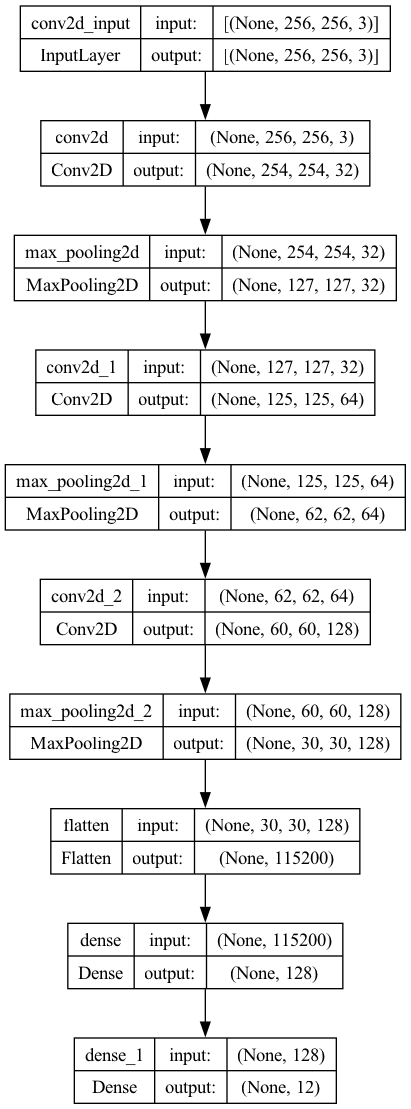

In [72]:
num_classes = len(train_generator.class_indices)
# Plot the model
plot_model(model_cnn1, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## Hypothesis test of model comparition

In [55]:
# Create a dictionary mapping models to their names

models = [model_cnn1, model_cnn2, model_cnn3, model_VGG16, model_resnet]

model_names = {
    model_cnn1: "model_cnn1",
    model_cnn2: "model_cnn2",
    model_cnn3: "model_cnn3",
    model_VGG16: "model_VGG16",
    model_resnet: "model_resnet"
}

In [60]:

def compare_models(model_A, model_B, validation_generator, model_names, alpha=0.05):
    predictions_A = []
    predictions_B = []
    true_labels = []

    for i in range(len(validation_generator)):
        X, y = validation_generator[i]
        true_labels.extend(y)

        preds_A = model_A.predict(X, verbose=0)
        preds_B = model_B.predict(X, verbose=0)

        predictions_A.extend(preds_A)
        predictions_B.extend(preds_B)

    predictions_A = np.array(predictions_A)
    predictions_B = np.array(predictions_B)
    true_labels = np.array(true_labels)

    predicted_labels_A = np.argmax(predictions_A, axis=1)
    predicted_labels_B = np.argmax(predictions_B, axis=1)
    true_labels = np.argmax(true_labels, axis=1)

    accuracy_A = accuracy_score(true_labels, predicted_labels_A)
    accuracy_B = accuracy_score(true_labels, predicted_labels_B)

    t_statistic, p_value = ttest_rel(predicted_labels_A, predicted_labels_B)

    model_A_name = model_names.get(model_A, 'Unknown Model A')
    model_B_name = model_names.get(model_B, 'Unknown Model B')
    
    # Print a blank line for separation and then the comparison header
    print("\nComparison between", model_A_name, "and", model_B_name)

    print(f"Accuracy {model_A_name}: {accuracy_A:.4f}")
    print(f"Accuracy {model_B_name}: {accuracy_B:.4f}")
    print(f"T-Statistic: {t_statistic:.4f}")
    print(f"P-Value: {p_value:.4f}")

    if p_value < alpha:
        print("Reject the null hypothesis. There is a significant difference.")
        if accuracy_A > accuracy_B:
            print(f"{model_A_name} is statistically significantly better than {model_B_name}.")
        else:
            print(f"{model_B_name} is statistically significantly better than {model_A_name}.")
    else:
        print("Fail to reject the null hypothesis. No significant difference.")
        if accuracy_A == accuracy_B:
            print(f"Both {model_A_name} and {model_B_name} have similar performance.")
        elif accuracy_A > accuracy_B:
            print(f"{model_A_name} is better, but not significantly.")
        else:
            print(f"{model_B_name} is better, but not significantly.")

    return accuracy_A, accuracy_B, p_value, "A" if accuracy_A > accuracy_B else "B" if accuracy_B > accuracy_A else "None"


In [5]:
compare_models(model_cnn1, model_cnn2, test_generator, model_names)

NameError: name 'compare_models' is not defined

In [71]:
models = [model_cnn1, model_cnn2, model_cnn3, model_VGG16, model_resnet]
model_scores = [0] * len(models)

for i in range(len(models)):
    for j in range(i + 1, len(models)):
        accuracy_A, accuracy_B, p_value, result = compare_models(models[i], models[j], validation_generator, model_names)
        
        # Update scores based on comparison results
        if result == "A":
            model_scores[i] += 1
        elif result == "B":
            model_scores[j] += 1
        # No update if result is "None" as there's no significant difference

# Rank models based on scores
ranked_models = sorted(range(len(models)), key=lambda x: model_scores[x], reverse=True)

# Print out the ranking
for rank, model_index in enumerate(ranked_models):
    model_name = model_names.get(models[model_index], f"Model {model_index + 1}")
    print(f"Rank {rank + 1}: {model_name} with {model_scores[model_index]} wins")



Comparison between model_cnn1 and model_cnn2
Accuracy model_cnn1: 0.9459
Accuracy model_cnn2: 0.9552
T-Statistic: 2.4633
P-Value: 0.0138
Reject the null hypothesis. There is a significant difference.
model_cnn2 is statistically significantly better than model_cnn1.

Comparison between model_cnn1 and model_cnn3
Accuracy model_cnn1: 0.9459
Accuracy model_cnn3: 0.9471
T-Statistic: 1.3770
P-Value: 0.1686
Fail to reject the null hypothesis. No significant difference.
model_cnn3 is better, but not significantly.

Comparison between model_cnn1 and model_VGG16
Accuracy model_cnn1: 0.9459
Accuracy model_VGG16: 0.9533
T-Statistic: 2.1763
P-Value: 0.0296
Reject the null hypothesis. There is a significant difference.
model_VGG16 is statistically significantly better than model_cnn1.

Comparison between model_cnn1 and model_resnet
Accuracy model_cnn1: 0.9459
Accuracy model_resnet: 0.4389
T-Statistic: 13.7538
P-Value: 0.0000
Reject the null hypothesis. There is a significant difference.
model_cnn1 

# Points to think about:
* generalisation of the model -> do not overfit
* Hypothesis testing 
* Evaluation Protocolls 
    * K-Fold Cross Validation
    * Nested Cross Validation 
* what is the best architecture for CNN???
* Hyperparameter TUNING
* Why Clustering does not make sense

## Websites where i have to look in 

* https://www.jeremyjordan.me/convnet-architectures/
* https://github.com/pedropro/TACO
* https://github.com/AgaMiko/waste-datasets-review/tree/main/img
* https://github.com/settings/copilot

Certainly! In addition to hypothesis testing, there are several other aspects you might want to check to ensure a comprehensive evaluation of your classification model. Here are some key considerations:

1. Confusion Matrix and Classification Report:
    * Analyze the confusion matrix to understand how well your model is performing for each class. It provides insights into true positives, true negatives, false positives, and false negatives.
    * Use the classification report to obtain precision, recall, and F1-score for each class.
2. ROC Curve and AUC:
    * If your problem is binary classification, consider plotting the ROC curve and calculating the Area Under the Curve (AUC) to assess the model's ability to discriminate between classes.
3. Cross-Validation:
    * Implement k-fold cross-validation to evaluate the model's performance on multiple train-test splits. This helps assess the model's generalization across different subsets of the data.
4. Learning Curves:
    * Plot learning curves to visualize the model's training and validation performance over epochs. This helps identify overfitting or underfitting issues.
5. Feature Importance:
    * If applicable, investigate feature importance. In image classification, this might not be as straightforward, but if you have extracted features from the images or are using a graph-based model, consider analyzing feature importance.
6. Model Interpretability:
    * Utilize techniques for model interpretability, such as SHAP (SHapley Additive exPlanations) values or LIME (Local Interpretable Model-agnostic Explanations), to understand the model's decision-making process.
7. Hyperparameter Tuning:
    * Experiment with different hyperparameter settings to optimize model performance. This could include learning rate, batch size, number of layers, etc.
8. Handling Class Imbalance:
    * If your dataset has imbalanced classes, explore techniques such as oversampling, undersampling, or using class weights to address the imbalance.
9. Error Analysis:
    * Analyze specific examples where the model fails to make accurate predictions. Understanding the types of errors can provide insights into potential improvements.
10. Deployment Considerations:
    * If you plan to deploy the model, consider additional factors such as model size, computational efficiency, and inference speed.
    * Remember that the evaluation process is an iterative one, and it's essential to tailor it to the specifics of your project and dataset. Adjust your evaluation strategy based on the insights gained from each step to iteratively improve your model.

***
## Hypothesis Definition 

In [ ]:
def load_images_into_dataframe(root_folder, image_extensions=['jpg', 'jpeg', 'png', 'gif', 'bmp'], batch_size=100):
    # Ensure the root folder path is valid
    if not os.path.exists(root_folder):
        print(f"Error: The folder '{root_folder}' does not exist.")
        return None

    data = {'Image': [], 'Label': []}

    # Function to load images in parallel
    def process_images(args):
        image_file, label = args
        try:
            # Load image using PIL
            img = Image.open(image_file)

            # Convert image to NumPy array
            img_array = np.array(img)

            # Append data to the dictionary
            data['Image'].append(img_array)
            data['Label'].append(label)
        except Exception as e:
            print(f"Error loading image {image_file}: {e}")

    # Iterate through subfolders
    for label in tqdm(os.listdir(root_folder), desc="Processing Subfolders", unit="subfolder"):
        label_path = os.path.join(root_folder, label)

        # Check if it's a directory
        if os.path.isdir(label_path):
            # Use ThreadPoolExecutor for parallel processing
            with ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
                image_files = []
                for ext in image_extensions:
                    image_files.extend(glob.glob(os.path.join(label_path, f'*.{ext}')))

                # Process images in batches
                label_image_pairs = [(image_file, label) for image_file in image_files]
                for i in tqdm(range(0, len(label_image_pairs), batch_size), desc="Processing Images", unit="batch"):
                    batch_files = label_image_pairs[i:i + batch_size]
                    executor.map(process_images, batch_files)

    # Convert the dictionary to a DataFrame
    df = pd.DataFrame(data)

    return df

# Example usage:
root_folder_path = '/Users/linuszarse/Documents/UNI/Master-Uni Potsdam/3. Semester/Machine Learning 2/Klausurprojekt/garbage_classification'
image_df = load_images_into_dataframe(root_folder_path)
image_df.head()


In [ ]:
from scipy.stats import ttest_rel
# Assuming you have true labels for the validation set
true_labels = validation_generator.classes  # Assuming you're using flow_from_directory

# Make predictions on the validation set
predicted_labels = model.predict(validation_generator)

# Convert predicted probabilities to class labels
predicted_labels = np.argmax(predicted_labels, axis=1)

# Calculate the test statistic (accuracy)
observed_accuracy = accuracy_score(true_labels, predicted_labels)

# Perform a paired t-test
t_statistic, p_value = ttest_rel(true_labels, predicted_labels)

# Choose a significance level (e.g., alpha = 0.05)
alpha = 0.05

# Check if the p-value is less than alpha
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference.")
else:
    print("Fail to reject the null hypothesis. No significant difference.")

In [ ]:
# Define the root folder path
root_folder_path = '/Users/linuszarse/Documents/UNI/Master-Uni Potsdam/3. Semester/Machine Learning 2/Klausurprojekt/garbage_classification'

# Gather all image paths and labels
file_paths = []
labels = []
for class_folder_name in os.listdir(root_folder_path):
    class_folder_path = os.path.join(root_folder_path, class_folder_name)
    if os.path.isdir(class_folder_path):
        for image_name in os.listdir(class_folder_path):
            image_path = os.path.join(class_folder_path, image_name)
            file_paths.append(image_path)
            labels.append(class_folder_name)

# Create a DataFrame
data = pd.DataFrame({'filename': file_paths, 'class': labels})

# Split the data into training, validation, and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42, stratify=data['class'])
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42, stratify=train_data['class'])  # 0.25 x 0.8 = 0.2

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create the training, validation, and test generators
train_generator = train_datagen.flow_from_dataframe(
    train_data,
    x_col='filename',
    y_col='class',
    target_size=target_size,
    class_mode='categorical',
    batch_size=32
)

validation_generator = val_datagen.flow_from_dataframe(
    val_data,
    x_col='filename',
    y_col='class',
    target_size=target_size,
    class_mode='categorical',
    batch_size=32
)

test_generator = test_datagen.flow_from_dataframe(
    test_data,
    x_col='filename',
    y_col='class',
    target_size=target_size,
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)



*** 
## Data Visualization

In [2]:
from sklearn.decomposition import PCA
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Define the root folder where your subfolders (class folders) are located
root_folder_path = '/Users/linuszarse/Documents/UNI/Master-Uni Potsdam/3. Semester/Machine Learning 2/Klausurprojekt/garbage_classification'

# Define the ImageDataGenerator for data augmentation and preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,       # Rescale pixel values to be between 0 and 1
    shear_range=0.2,      # Shear transformation
    zoom_range=0.2,       # Random zoom
    horizontal_flip=True, # Random horizontal flip
    validation_split=0.2  # Split data into training and validation sets
)

# Define the target image size
target_size = (224, 224)  # Adjust according to your model's input size

# Create the training data generator
train_generator = datagen.flow_from_directory(
    root_folder_path,
    target_size=target_size,
    batch_size=32,         # Adjust based on your system's memory
    class_mode='categorical',  # Assumes a classification task
    subset='training'      # Specify 'training' for training data
)

# Create the validation data generator
validation_generator = datagen.flow_from_directory(
    root_folder_path,
    target_size=target_size,
    batch_size=32,
    class_mode='categorical',
    subset='validation'    # Specify 'validation' for validation data
)

# Load the VGG16 model without the top (fully connected) layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Extract features for training data using the VGG16 model
train_features = base_model.predict(train_generator, steps=len(train_generator), verbose=1)

# Reshape the features to 2D array
train_features = train_features.reshape(train_features.shape[0], -1)

# Apply PCA
n_components = 100  # Adjust this based on your needs
pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(train_features)

# 'pca_result' now contains the reduced-dimensional representation of your training data
# You can use 'pca_result' for further analysis or modeling


Found 12415 images belonging to 12 classes.
Found 3100 images belonging to 12 classes.
388/388 [==============================] - 4377s 11s/step
